In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [4]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


Funkcja `to_patches` przekształca obraz o wymiarach (batch, channels, height, width) na batch sekwencji małych patchy dzieląc każdy obraz na prostokątne fragmenty o określonym rozmiarze, a następnie spłaszczając je do wektorów. Proces obejmuje wyodrębnienie patch-y wzdłuż osi wysokości i szerokości, a następnie przekształcenie ich w jednowymiarowe reprezentacje.

In [5]:
def to_patches(image, patch_size):
    num_patches_h = image.shape[2] // patch_size
    num_patches_w = image.shape[3] // patch_size
    image = image.permute(0, 2, 3, 1)
    image = image.view(image.shape[0], num_patches_h, patch_size, num_patches_w, patch_size, image.shape[3])
    patches = image.permute(0, 1, 3, 2, 4, 5).contiguous()
    patches = patches.view(patches.shape[0], -1, patch_size * patch_size * patches.shape[-1])
    return patches


In [6]:
import math

def display_patches(image, patch_size, title="Patches"):
    patches = to_patches(image, patch_size)
    num_patches = patches.shape[1]
    grid_size = math.ceil(math.sqrt(num_patches))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
    fig.suptitle(title, fontsize=16)
    axs = axs.flatten()
    
    for i in range(len(axs)):
        if i < num_patches:
            patch = patches[0, i].view(patch_size, patch_size, -1).permute(2, 0, 1)
            axs[i].imshow(patch.permute(1, 2, 0).numpy())
        axs[i].axis('off')
        
    plt.tight_layout()
    plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

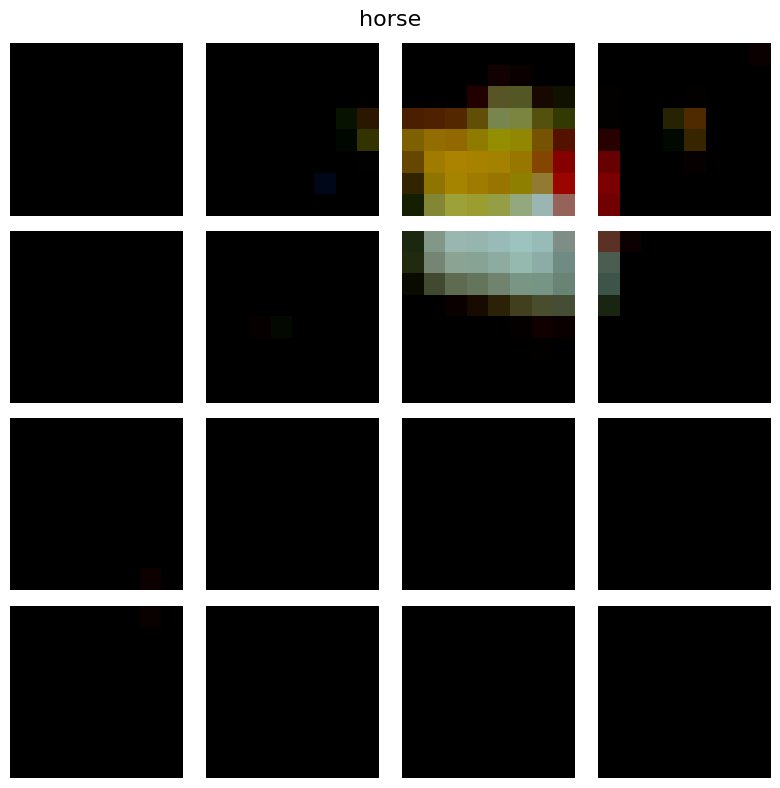

In [7]:
images, labels = next(iter(train_loader))
label_name = train_dataset.classes[labels[0]]
display_patches(images[:1], patch_size=8, title=label_name)

In [8]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim=256, patch_size=4, in_channels=3):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
    
        self.l = nn.Linear(patch_size * patch_size * in_channels, embed_dim)
        
    def forward(self, x):
        x = to_patches(x, patch_size=self.patch_size)
        return self.l(x)

In [9]:
class MyMultiheadAttention(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8):
        super(MyMultiheadAttention, self).__init__()
        self.mha = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads)
    def forward(self, x):
        return self.mha(x, x, x)

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim=256, dropout_prob=0.1):
        super(TransformerBlock, self).__init__()

        self.dropout_prob = dropout_prob

        self.resblock_1 = nn.Sequential(
            nn.LayerNorm(embed_dim),
            MyMultiheadAttention(embed_dim=embed_dim),
        )

        self.resblock_2 = nn.Sequential(
            nn.LayerNorm(embed_dim),
            nn.Linear(embed_dim, 512),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, embed_dim),
            nn.Dropout(dropout_prob),
        )

    def forward(self, x):
        y, _ = self.resblock_1(x)
        x = x + y
        y = self.resblock_2(x)
        return x + y

In [10]:
# class AddPositionalEmbedding(nn.Module):
#     def __init__(self, positional_embedding):
#         super(AddPositionalEmbedding, self).__init__()
#         self.positional_embedding = positional_embedding
# 
#     def forward(self, x):
#         return x + self.positional_embedding
# 
# class ViT(nn.Module):
#     def __init__(self, image_size=32, embed_dim=256, patch_size=4, in_channels=3, output_size=10, dropout_prob=0.1):
#         super(ViT, self).__init__()
#         num_patches = (image_size // patch_size) ** 2
# 
#         self.positional_embedding = nn.Parameter(torch.randn(1, num_patches, embed_dim))
# 
#         self.vit = nn.Sequential(
#             PatchEmbedding(embed_dim=embed_dim, patch_size=patch_size, in_channels=in_channels),
#             AddPositionalEmbedding(self.positional_embedding),
# 
#             TransformerBlock(embed_dim=embed_dim, dropout_prob=dropout_prob),
#             TransformerBlock(embed_dim=embed_dim, dropout_prob=dropout_prob),
#             TransformerBlock(embed_dim=embed_dim, dropout_prob=dropout_prob),
#             TransformerBlock(embed_dim=embed_dim, dropout_prob=dropout_prob),
#             TransformerBlock(embed_dim=embed_dim, dropout_prob=dropout_prob),
#             TransformerBlock(embed_dim=embed_dim, dropout_prob=dropout_prob),
# 
#             nn.LayerNorm(embed_dim),
#             nn.Linear(embed_dim, output_size)
# 
#         )
#     def forward(self, x):
#         x = self.vit(x)
#         x = torch.mean(x, dim=1)
#         return x


class ViT(nn.Module):
    def __init__(self, image_size=32, patch_size=4, in_channels=3, embed_size=256, output_size=10):
        super().__init__()
        self.patch_embedding = PatchEmbedding(embed_dim=embed_size, patch_size=patch_size, in_channels=in_channels)
        num_patches = (image_size // patch_size) ** 2
        self.positional_encoding = nn.Parameter(torch.randn(1, num_patches, embed_size))

        transformers = [
            TransformerBlock(
                embed_dim=embed_size
            )
        ] * 6

        self.transformers = nn.Sequential(*transformers)

        self.linear = nn.Linear(embed_size, output_size)

    def forward(self, x):
        x = self.patch_embedding(x)
        x += self.positional_encoding
        x = self.transformers(x)
        x = x.mean(dim=1)
        x = self.linear(x)
        return x

In [11]:
from copy import deepcopy

In [12]:
learning_rate = 0.002
num_epochs = 160
lr_drop_epochs = [100, 150]

In [13]:
model = ViT()
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

best_val_loss = torch.inf
best_model = None

pbar = tqdm(total=len(train_loader)*num_epochs, dynamic_ncols=True)
for epoch in range(num_epochs):
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        y_pred = model(X_batch)
        
        loss = loss_fn(y_pred, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        
        pbar.update(1)
        pbar.set_description(f"Loss: {loss.item():.4f}")
    
    if running_loss<best_val_loss:
        best_val_loss = running_loss
        best_model = deepcopy(model)
    
    if epoch in lr_drop_epochs:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
            
    if epoch % 1 == 0:
        print(f"{epoch+1}/160 - Loss: {(running_loss/len(train_loader)):.4f}")
            
torch.save(best_model.state_dict(), "best_model.pth")
        

  0%|          | 0/62560 [00:00<?, ?it/s]

1/160 - Loss: 1.8037
2/160 - Loss: 1.4637
3/160 - Loss: 1.3522
4/160 - Loss: 1.2775
5/160 - Loss: 1.2312
6/160 - Loss: 1.1857
7/160 - Loss: 1.1510
8/160 - Loss: 1.1192
9/160 - Loss: 1.0945
10/160 - Loss: 1.0537
11/160 - Loss: 1.0234
12/160 - Loss: 0.9969
13/160 - Loss: 0.9776
14/160 - Loss: 0.9618
15/160 - Loss: 0.9393
16/160 - Loss: 0.9296
17/160 - Loss: 0.9181
18/160 - Loss: 0.9087
19/160 - Loss: 0.8965
20/160 - Loss: 0.8910
21/160 - Loss: 0.8814
22/160 - Loss: 0.8705
23/160 - Loss: 0.8660
24/160 - Loss: 0.8633
25/160 - Loss: 0.8523
26/160 - Loss: 0.8445
27/160 - Loss: 0.8379
28/160 - Loss: 0.8326
29/160 - Loss: 0.8271
30/160 - Loss: 0.8193
31/160 - Loss: 0.8168
32/160 - Loss: 0.8164
33/160 - Loss: 0.8094
34/160 - Loss: 0.8029
35/160 - Loss: 0.7975
36/160 - Loss: 0.7891
37/160 - Loss: 0.7890
38/160 - Loss: 0.7802
39/160 - Loss: 0.7774
40/160 - Loss: 0.7736
41/160 - Loss: 0.7684
42/160 - Loss: 0.7604
43/160 - Loss: 0.7596
44/160 - Loss: 0.7552
45/160 - Loss: 0.7488
46/160 - Loss: 0.73

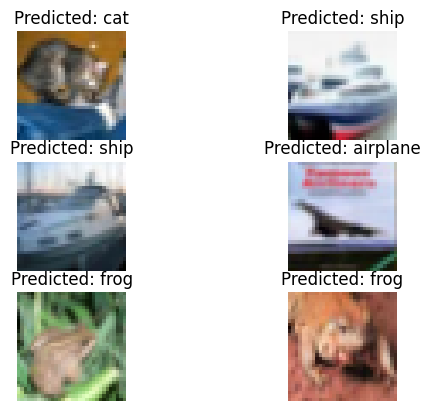

In [18]:
plt.ion()

def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {train_dataset.classes[preds[j]]}')

                img = inputs[j].cpu().numpy().transpose((1, 2, 0))  # Zmiana z [C, H, W] na [H, W, C]
                img = (img - img.min()) / (img.max() - img.min())  # Normalizacja do zakresu [0, 1]
                plt.imshow(img)

                if images_so_far == num_images:
                    plt.show()
                    return
                
visualize_model(best_model)

In [15]:
class_correct = list(0. for _ in range(10))
class_total = list(0. for _ in range(10))

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        outputs = best_model(X_test_batch.to(device))
        _, predicted = torch.max(outputs, 1)
        c = (predicted == y_test_batch.to(device)).squeeze()

        for i in range(y_test_batch.size(0)):
            label = y_test_batch[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f'Accuracy of {train_dataset.classes[i]}: {accuracy}%')

Accuracy of airplane: 81.0%
Accuracy of automobile: 87.9%
Accuracy of bird: 69.8%
Accuracy of cat: 60.7%
Accuracy of deer: 74.8%
Accuracy of dog: 69.3%
Accuracy of frog: 83.6%
Accuracy of horse: 82.4%
Accuracy of ship: 87.0%
Accuracy of truck: 87.2%
